<a href="https://colab.research.google.com/github/suyashstr/Stock-Price-Prediction/blob/main/Healthcare_System_(Using_Spatio_Temporal_Data_Analytics).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
#Importing Dependecies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv2D, MaxPooling2D, Flatten
# Load the dataset (make sure to provide the correct path to the CSV file)
df = pd.read_csv('covid_19_india.csv')

###Overview of Dataset

In [5]:
# Display the first few rows to understand the data
print(df.head())

# Basic information about the dataset
print(df.info())  # Check for missing values
print(df.isnull().sum())

# List of crucial columns
crucial_columns = ['Date', 'State/UnionTerritory', 'ConfirmedIndianNational', 'ConfirmedForeignNational', 'Cured', 'Deaths', 'Confirmed']


   Sno        Date     Time State/UnionTerritory ConfirmedIndianNational  \
0    1  2020-01-30  6:00 PM               Kerala                       1   
1    2  2020-01-31  6:00 PM               Kerala                       1   
2    3  2020-02-01  6:00 PM               Kerala                       2   
3    4  2020-02-02  6:00 PM               Kerala                       3   
4    5  2020-02-03  6:00 PM               Kerala                       3   

  ConfirmedForeignNational  Cured  Deaths  Confirmed  
0                        0      0       0          1  
1                        0      0       0          1  
2                        0      0       0          2  
3                        0      0       0          3  
4                        0      0       0          3  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18110 entries, 0 to 18109
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----

###Data Preprocessing and Cleaning

In [6]:
# Filter only the columns that exist in the DataFrame
existing_columns = [col for col in crucial_columns if col in df.columns]

# Drop rows where any of the crucial columns that exist are missing
df = df.dropna(subset=existing_columns)

# Convert 'Date' column to datetime without dayfirst (since date is in YYYY-MM-DD format)
df['Date'] = pd.to_datetime(df['Date'], dayfirst=False)

# Check the data again
print(df.head())
# Group the data by 'Date' and 'State/UnionTerritory' for time-series analysis
df_grouped = df.groupby(['Date', 'State/UnionTerritory']).sum().reset_index()

# Check the grouped data
print(df_grouped.head())

# Fill missing values (if any) in the grouped data
df_pivot = df_grouped.pivot(index='Date', columns='State/UnionTerritory', values='Confirmed')
df_pivot = df_pivot.fillna(0)


   Sno       Date     Time State/UnionTerritory ConfirmedIndianNational  \
0    1 2020-01-30  6:00 PM               Kerala                       1   
1    2 2020-01-31  6:00 PM               Kerala                       1   
2    3 2020-02-01  6:00 PM               Kerala                       2   
3    4 2020-02-02  6:00 PM               Kerala                       3   
4    5 2020-02-03  6:00 PM               Kerala                       3   

  ConfirmedForeignNational  Cured  Deaths  Confirmed  
0                        0      0       0          1  
1                        0      0       0          1  
2                        0      0       0          2  
3                        0      0       0          3  
4                        0      0       0          3  
        Date State/UnionTerritory  Sno     Time ConfirmedIndianNational  \
0 2020-01-30               Kerala    1  6:00 PM                       1   
1 2020-01-31               Kerala    2  6:00 PM                      

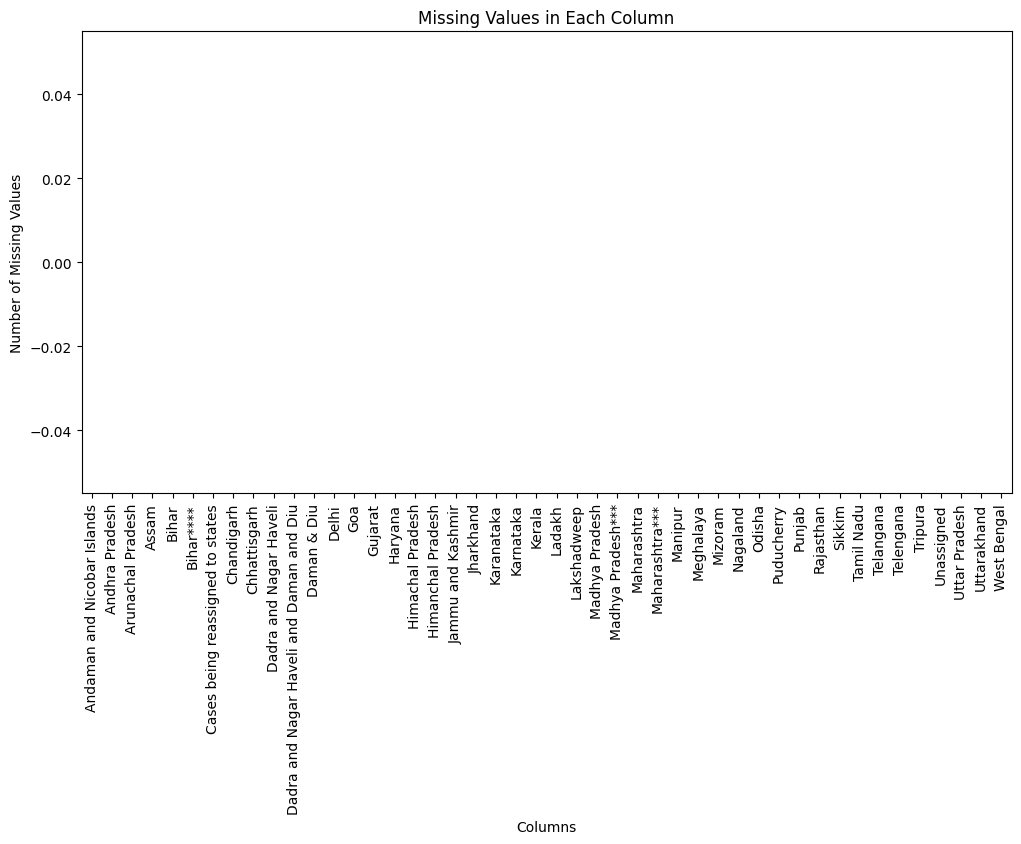

[[-1.28255831 -1.11912697 -1.00218611 -1.08003854 -0.98083738 -0.05986843
  -0.31092025 -0.91062577 -0.83515824 -0.05986836 -0.98621268 -0.04229549
  -1.02756689 -0.91014086 -0.91685645 -0.91441984 -0.78386462 -0.04229549
  -1.00067869 -0.94217087 -0.04229549 -0.93269599 -0.80285801 -1.06355658
  -0.49065121 -0.88987985 -0.04229549 -0.96540942 -0.04229549 -0.89861015
  -0.77207543 -0.61654849 -1.0638294  -0.96486557 -0.93936012 -0.88842611
  -0.89264821 -0.80860881 -0.99162047 -0.46962651 -0.92900313 -1.1168791
  -0.07001377 -0.95309267 -0.82616818 -0.94876462]
 [-1.28255831 -1.11912697 -1.00218611 -1.08003854 -0.98083738 -0.05986843
  -0.31092025 -0.91062577 -0.83515824 -0.05986836 -0.98621268 -0.04229549
  -1.02756689 -0.91014086 -0.91685645 -0.91441984 -0.78386462 -0.04229549
  -1.00067869 -0.94217087 -0.04229549 -0.93269599 -0.80285801 -1.06355658
  -0.49065121 -0.88987985 -0.04229549 -0.96540942 -0.04229549 -0.89861015
  -0.77207543 -0.61654849 -1.0638294  -0.96486557 -0.93936012 

In [7]:
# Bar chart for missing values in each column
missing_values = df_pivot.isnull().sum()

# Create a bar chart to visualize the missing values
plt.figure(figsize=(12, 6))
missing_values.plot(kind='bar', color='orange')
plt.title("Missing Values in Each Column")
plt.xlabel("Columns")
plt.ylabel("Number of Missing Values")
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.show()

# We will now scale the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_pivot)

# Show scaled data preview
print(scaled_data[:5])



In [8]:
# Function to create sequences for LSTM model input
def create_sequences(data, seq_length):
    X = []
    y = []

    for i in range(seq_length, len(data)):
        X.append(data[i - seq_length:i])
        y.append(data[i])

    return np.array(X), np.array(y)

# Set sequence length
SEQ_LENGTH = 14  # Using 14 days as history for prediction
X, y = create_sequences(scaled_data, SEQ_LENGTH)

# Shape of X should be (number_of_samples, seq_length, number_of_features)
print(X.shape, y.shape)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set: {X_train.shape}, Test set: {X_test.shape}")

(546, 14, 46) (546, 46)
Training set: (436, 14, 46), Test set: (110, 14, 46)


In [9]:
# Build the LSTM model
model_lstm = Sequential()
model_lstm.add(LSTM(units=64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(units=64, return_sequences=False))
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(units=1, activation='linear'))  # Linear activation for continuous output

# Compile the model
model_lstm.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history_lstm = model_lstm.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate the model
loss_lstm, mae_lstm = model_lstm.evaluate(X_test, y_test)
print(f"LSTM Model - Test MAE: {mae_lstm:.2f}")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 69ms/step - loss: 0.6955 - mae: 0.5073 - val_loss: 0.3918 - val_mae: 0.3521
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.4544 - mae: 0.3617 - val_loss: 0.3407 - val_mae: 0.3766
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.4304 - mae: 0.3262 - val_loss: 0.3326 - val_mae: 0.3274
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.3693 - mae: 0.3429 - val_loss: 0.3289 - val_mae: 0.3450
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.3090 - mae: 0.2998 - val_loss: 0.3279 - val_mae: 0.3424
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.4368 - mae: 0.3316 - val_loss: 0.3269 - val_mae: 0.3484
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.4285 - mae: 0.3215 - val_loss: 0.3285 - val_mae: 0.3317
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.4975 - mae: 0.3175 - val_loss: 0.3264 - val_mae: 0.3470
Epoch 9/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.360

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


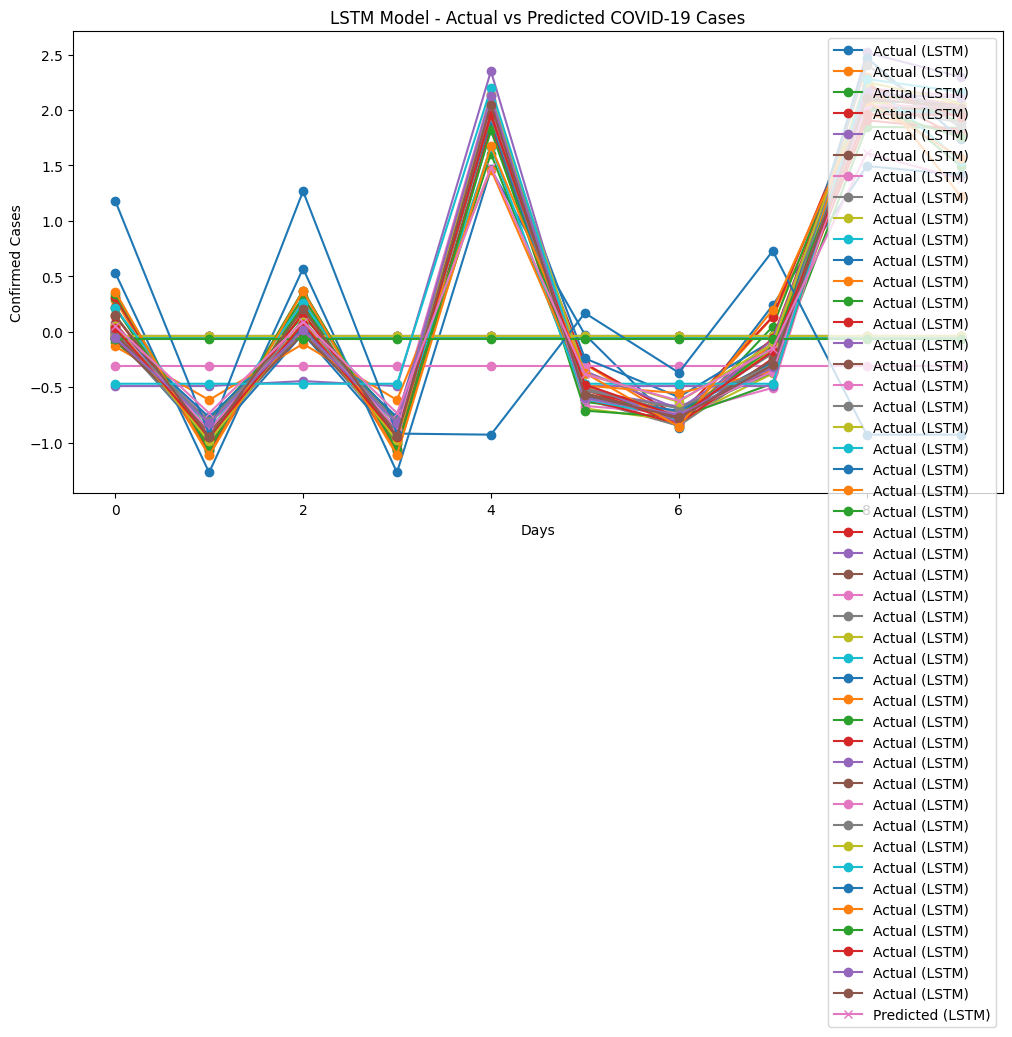

In [13]:
# Make predictions with LSTM model
y_pred_lstm = model_lstm.predict(X_test)

# Plot the actual vs predicted cases for LSTM model
plt.figure(figsize=(12, 6))
plt.plot(y_test[:10], label='Actual (LSTM)', marker='o')
plt.plot(y_pred_lstm[:10], label='Predicted (LSTM)', marker='x')
plt.title("LSTM Model - Actual vs Predicted COVID-19 Cases")
plt.xlabel("Days")
plt.ylabel("Confirmed Cases")
plt.legend()
plt.show()


In [14]:
# Reshape the data for CNN input format (samples, height, width, features)
# Let's treat each state as a "spatial" feature
X_train_cnn = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2], 1))
X_test_cnn = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2], 1))


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - loss: 0.6169 - mae: 0.4393 - val_loss: 0.3782 - val_mae: 0.3592
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.5477 - mae: 0.3394 - val_loss: 0.3483 - val_mae: 0.3681
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.5051 - mae: 0.3429 - val_loss: 0.3381 - val_mae: 0.3552
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.4961 - mae: 0.3218 - val_loss: 0.3336 - val_mae: 0.3583
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.3446 - mae: 0.2982 - val_loss: 0.3349 - val_mae: 0.3596
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.4025 - mae: 0.3170 - val_loss: 0.3307 - val_mae: 0.3399
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.3989 - mae: 0.3204 - val_loss: 0.3421 - val_mae: 0.3655
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.5204 - mae: 0.3476 - val_loss: 0.3340 - val_mae: 0.3549
Epoch 9/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.3487 - mae: 0

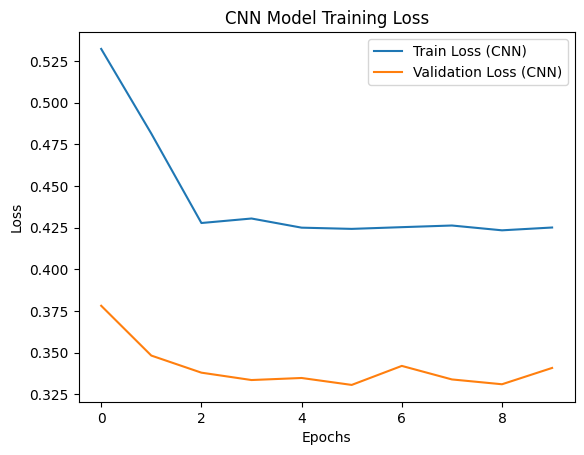

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


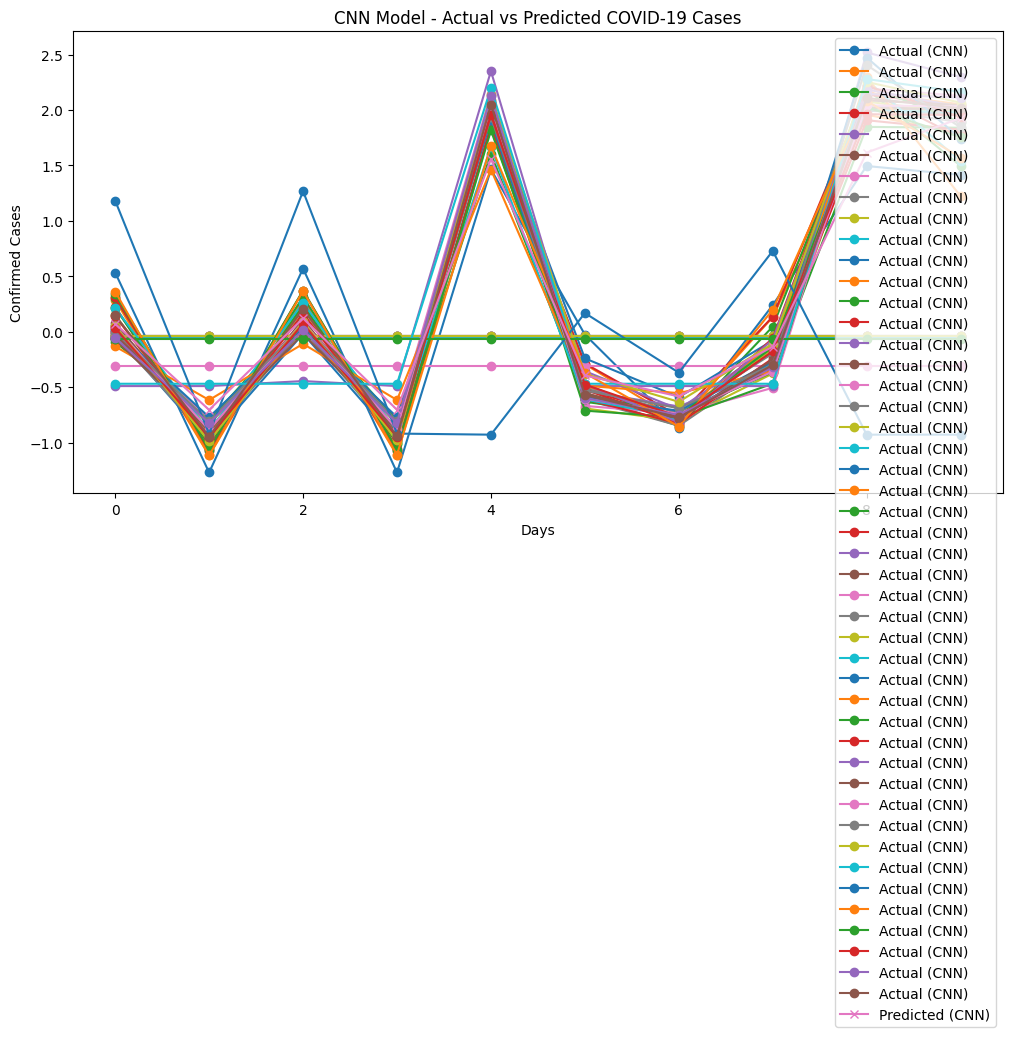

In [15]:
# Build the CNN model
model_cnn = Sequential()
model_cnn.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(X_train_cnn.shape[1], X_train_cnn.shape[2], X_train_cnn.shape[3])))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))
model_cnn.add(Flatten())
model_cnn.add(Dense(64, activation='relu'))
model_cnn.add(Dense(1, activation='linear'))  # Linear activation for continuous output

# Compile the CNN model
model_cnn.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the CNN model
history_cnn = model_cnn.fit(X_train_cnn, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate the CNN model
loss_cnn, mae_cnn = model_cnn.evaluate(X_test_cnn, y_test)
print(f"CNN Model - Test MAE: {mae_cnn:.2f}")

# Plot training and validation loss for CNN
plt.plot(history_cnn.history['loss'], label='Train Loss (CNN)')
plt.plot(history_cnn.history['val_loss'], label='Validation Loss (CNN)')
plt.title("CNN Model Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Make predictions with CNN model
y_pred_cnn = model_cnn.predict(X_test)

# Plot the actual vs predicted cases for CNN model
plt.figure(figsize=(12, 6))
plt.plot(y_test[:10], label='Actual (CNN)', marker='o')
plt.plot(y_pred_cnn[:10], label='Predicted (CNN)', marker='x')
plt.title("CNN Model - Actual vs Predicted COVID-19 Cases")
plt.xlabel("Days")
plt.ylabel("Confirmed Cases")
plt.legend()
plt.show()

